In [2]:
import re
import string
import numpy as np
import pandas as pd
import scipy as sp
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, ensemble, model_selection
import xgboost as xg
import validators as vld


In [3]:
df_train = pd.read_csv('./train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Cleaning corpora

In [4]:
PUNCTUATION = set(string.punctuation)
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))
lemm = nltk.WordNetLemmatizer()

In [5]:
def is_not_stopword(word):
    return word not in STOP_WORDS

def is_not_number(token):
    return not token.isdigit()

def is_not_url(token):
    return not vld.url(token)

def remove_punctuation(input):
    return ''.join([c for c in input if c not in PUNCTUATION])

def clean_text(input):
    tokens = re.split('\\s+', input.lower())
    tokens = filter(is_not_url, tokens)
    tokens = filter(is_not_stopword, tokens)
    tokens = map(remove_punctuation, tokens)
    tokens = filter(is_not_number, tokens)
    tokens = map(lemm.lemmatize, tokens)
    return ' '.join(tokens)


df_train['clean_text'] = df_train['text'].apply(clean_text)

df_train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


## Vectorizing

In [6]:
count_vect = feature_extraction.text.TfidfVectorizer(max_features=2000)
train_vectors = count_vect.fit_transform(df_train['clean_text'])
train_vectors.shape

(7613, 2000)

In [7]:
count_vect.get_feature_names_out()[10:1000:10]

array(['70th', 'accident', 'add', 'again', 'aircraft', 'alert', 'always',
       'ancient', 'another', 'apocalypse', 'arianagrande', 'article',
       'attention', 'averted', 'bagging', 'battle', 'beautiful', 'ben',
       'biggest', 'blaze', 'blog', 'body', 'boy', 'broad', 'budget',
       'burst', 'ca', 'calorie', 'canyon', 'case', 'cdt', 'charity',
       'chinese', 'class', 'cnn', 'collision', 'company', 'confirm',
       'cook', 'court', 'cream', 'crossed', 'cyclone', 'dangerous',
       'deadly', 'degree', 'derail', 'destruction', 'different',
       'displaced', 'done', 'dream', 'drought', 'dy', 'ebay',
       'electrocute', 'enemy', 'epic', 'evacuation', 'evil', 'expected',
       'eye', 'fall', 'fat', 'feed', 'fight', 'firefighter', 'flattened',
       'follower', 'forever', 'freakiest', 'fuel', 'game', 'general',
       'giving', 'gone', 'great', 'gta', 'ha', 'happening', 'he', 'held',
       'hey', 'hiring', 'homeless', 'hour', 'hurt', 'ie', 'impact',
       'info', 'interes

## Features engineering

In [8]:
def move_target_rigth(df):
    target = df['target']
    df = df.drop(['target'], axis=1)
    df['target'] = target
    return df

df_train['text_length'] = df_train['text'].apply(lambda txt: len(txt)-txt.count(' '))
df_train['upper_text_length'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c.isupper()))
df_train['upper_text_factor'] = df_train['upper_text_length']/df_train['text_length']
df_train['tags_count'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c=='#'))
df_train['punct_factor'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c in PUNCTUATION)) / df_train['text_length']
df_train['ann_count'] = df_train['text'].apply(lambda txt: sum(1 for c in txt if c=='@'))
df_train['urls_count'] = df_train['text'].apply(lambda txt: len(list(filter(vld.url, txt.split(' ')))))

df_train = move_target_rigth(df_train)


In [9]:
df_train.iloc[0:500:25,:]

,id,keyword,location,text,clean_text,text_length,upper_text_length,upper_text_factor,tags_count,punct_factor,ann_count,urls_count,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u,57,10,0.175439,1,0.017544,0,0,1
25,37,NaN,NaN,No way...I can't eat that shit,wayi cant eat shit,25,2,0.080000,0,0.160000,0,0,0
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ab...,deputy man shot brighton home set ablaze,65,9,0.138462,0,0.092308,0,1,1
75,109,accident,NaN,RT @SleepJunkies: Sleeping pills double your r...,rt sleepjunkies sleeping pill double risk car ...,79,8,0.101266,0,0.088608,1,1,0
100,144,accident,UK,.@NorwayMFA #Bahrain police had previously die...,norwaymfa bahrain police previously died road ...,108,8,0.074074,1,0.074074,1,1,1
125,180,aftershock,304,Sometimes you face difficulties not because yo...,sometimes face difficulty something wrong some...,110,3,0.027273,0,0.036364,0,0,0
150,215,airplane%20accident,"New Mexico, USA",@mickinyman @TheAtlantic That or they might be...,mickinyman theatlantic might killed airplane a...,105,4,0.038095,0,0.047619,2,0,0
175,251,ambulance,"New Orleans, LA",Leading emergency services boss welcomes new a...,leading emergency service bos welcome new ambu...,77,4,0.051948,0,0.064935,0,1,0
200,281,ambulance,VISIT MY YOUTUBE CHANNEL.,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...,happening hatzolah em ambulance responding du...,86,67,0.779070,0,0.081395,0,1,0
225,320,annihilated,NaN,70 years since we annihilated 100000 people in...,year since annihilated people instantly became...,110,0,0.000000,0,0.000000,0,0,1


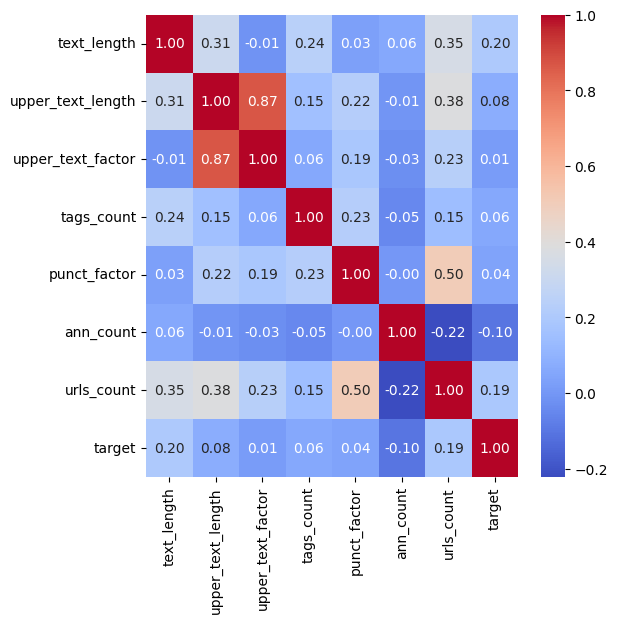

In [10]:
df_corr = df_train[['text_length','upper_text_length', 'upper_text_factor', 'tags_count', 'punct_factor', 'ann_count', 'urls_count', 'target']].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=df_corr.columns, yticklabels=df_corr.columns)
plt.show()

## Features selection

In [24]:
X_train = pd.DataFrame.sparse.from_spmatrix(train_vectors)
X_train['text_length'] = df_train['text_length']
X_train['urls_count'] = df_train['urls_count']
Y_train = df_train['target']
X_train.columns = X_train.columns.astype(str)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Columns: 2002 entries, 0 to urls_count
dtypes: Sparse[float64, 0](2000), int64(2)
memory usage: 663.7 KB


## Model selection

In [25]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,text_length,urls_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,57,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,112,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,57,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,72,0


In [26]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [100, None]
}
model = ensemble.RandomForestClassifier(n_jobs=2)
grid = model_selection.GridSearchCV(model, params, cv=5, n_jobs=2, scoring='f1', verbose=3)
grid.fit(X_train.to_numpy(), Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV 2/5] END ....max_depth=70, n_estimators=100;, score=0.445 total time=   4.3s
[CV 1/5] END ....max_depth=70, n_estimators=100;, score=0.499 total time=   4.6s
[CV 3/5] END ....max_depth=70, n_estimators=100;, score=0.495 total time=   5.1s
[CV 4/5] END ....max_depth=70, n_estimators=100;, score=0.405 total time=   5.0s
[CV 5/5] END ....max_depth=70, n_estimators=100;, score=0.620 total time=   6.9s
[CV 1/5] END ....max_depth=70, n_estimators=200;, score=0.506 total time=  13.0s
[CV 2/5] END ....max_depth=70, n_estimators=200;, score=0.458 total time=  12.9s
[CV 3/5] END ....max_depth=70, n_estimators=200;, score=0.495 total time=  11.4s
[CV 4/5] END ....max_depth=70, n_estimators=200;, score=0.429 total time=  11.9s
[CV 5/5] END ....max_depth=70, n_estimators=200;, score=0.615 total time=  11.9s
[CV 1/5] END ...max_depth=100, n_estimators=100;, score=0.516 total time=   7.4s
[CV 2/5] END ...max_depth=100, n_estimators=100;, score=0.462 total time=   7.2s
[CV 3/5] END ...max_depth=10

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=2), n_jobs=2,
             param_grid={'max_depth': [70, 100, None],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=3)

In [27]:
grid.best_params_, grid.best_score_

({'max_depth': None, 'n_estimators': 200}, 0.5268848964595101)

In [143]:
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [100, 130],
    'max_depth': [50, 70]
}
model = xg.XGBClassifier()
grid = model_selection.GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='f1', verbose=3)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.2, max_depth=50, n_estimators=100;, score=0.579 total time=  39.7s
[CV 3/5] END learning_rate=0.2, max_depth=50, n_estimators=100;, score=0.521 total time=  42.6s
[CV 2/5] END learning_rate=0.2, max_depth=50, n_estimators=100;, score=0.504 total time=  43.5s
[CV 5/5] END learning_rate=0.2, max_depth=50, n_estimators=100;, score=0.649 total time=  44.4s
[CV 4/5] END learning_rate=0.2, max_depth=50, n_estimators=100;, score=0.467 total time=  44.8s
[CV 3/5] END learning_rate=0.2, max_depth=50, n_estimators=130;, score=0.525 total time=  50.8s
[CV 1/5] END learning_rate=0.2, max_depth=50, n_estimators=130;, score=0.584 total time=  53.9s
[CV 2/5] END learning_rate=0.2, max_depth=50, n_estimators=130;, score=0.509 total time=  57.4s
[CV 5/5] END learning_rate=0.2, max_depth=50, n_estimators=130;, score=0.644 total time=  55.1s
[CV 1/5] END learning_rate=0.2, max_depth=70, n_estimators=100;, score=0.58

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3, 0.4],
                         'max_depth': [50, 70], 'n_estimators': [100, 130]},
             scoring='f1', verbose=3)

In [144]:
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')[0:5].T
results

,3,5,4,2,6
mean_fit_time,64.570168,49.828529,42.180478,60.640564,50.84793
std_fit_time,5.610396,1.587964,1.764037,3.725105,0.910546
mean_score_time,1.285648,1.149032,1.27392,1.48139,1.259953
std_score_time,0.113405,0.106994,0.187176,0.247323,0.170656
param_learning_rate,0.2,0.3,0.3,0.2,0.3
param_max_depth,70,50,50,70,70
param_n_estimators,130,130,100,100,100
params,"{'learning_rate': 0.2, 'max_depth': 70, 'n_est...","{'learning_rate': 0.3, 'max_depth': 50, 'n_est...","{'learning_rate': 0.3, 'max_depth': 50, 'n_est...","{'learning_rate': 0.2, 'max_depth': 70, 'n_est...","{'learning_rate': 0.3, 'max_depth': 70, 'n_est..."
split0_test_score,0.594752,0.60554,0.590385,0.588008,0.605769
split1_test_score,0.519793,0.511709,0.511304,0.520994,0.505263


In [145]:
grid.best_params_, grid.best_score_

({'learning_rate': 0.2, 'max_depth': 70, 'n_estimators': 130},
 0.5547965221998632)